# Digit Recognizer

In [106]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

train_df = pd.read_csv('./data/train.csv', sep=',')
train_df.head()
print(train_df.shape)
print(len(train_df))

(42000, 785)
42000


In [107]:
X_train = train_df.drop(labels=['label'], axis=1)
y_train = train_df['label']

y_train.head()

0    1
1    0
2    1
3    4
4    0
Name: label, dtype: int64

In [108]:
x = X_train.iloc[0]
x_np = np.array(x)
print(f'Previous shape = {x_np.shape}')
x_np = np.resize(x_np, (28, 28))
print(f'New shape = {x_np.shape}')
print(x_np)

Previous shape = (784,)
New shape = (28, 28)
[[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0 188 255  94   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0 191 250 253  93   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
  123 248 253 167  10   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0  80
  247 253 208  13   0   0   0   0   0   0]
 [  0   0   0   0  

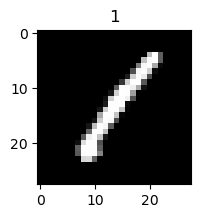

In [109]:
fig = plt.figure(figsize=(2, 2))
ax = fig.add_subplot(1, 1, 1)
ax.imshow(x_np, cmap='gray')
ax.set_title(y_train[0])
plt.show()

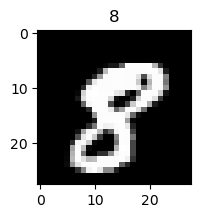

In [110]:
def show_digit(sample):
    """Show digit from pixels."""
    x, y = sample.drop('label'), sample['label']
    x_np = np.asarray(x, dtype=np.float32).reshape(28, 28)
    fig = plt.figure(figsize=(2, 2))
    ax = fig.add_subplot(1, 1, 1)
    ax.imshow(x_np, cmap='gray')
    ax.set_title(y)
    plt.show()

show_digit(train_df.iloc[10])

## Creating the Dataloader

In [149]:
import os
import torch
from torch.utils.data import DataLoader, Dataset
from torchvision.transforms import ToTensor
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings('ignore')

plt.ion()  # interactive mode

device = (torch.accelerator.current_accelerator().type  # type: ignore
          if torch.accelerator.is_available()
          else 'cpu')
print(f'Using {device} device')

class DigitDataset(Dataset):
    """Digit dataset."""

    def __init__(self, root, train, transform=None):
        self.csv_path = os.path.join(root, 'train.csv')
        self.data = pd.read_csv(self.csv_path, sep=',')
        self.train = train

        self.train_data, self.test_data = train_test_split(
            self.data,
            test_size=0.3,
            shuffle=True)
            
        self.transform = transform

    def __len__(self):
        if self.train:
            return len(self.train_data)
        return len(self.test_data)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        if self.train:
            sample = self.train_data.iloc[idx]
        else:
            sample = self.test_data.iloc[idx]

        img, label = sample.drop('label'), sample['label']
        img = np.asarray(img, dtype=np.float32).reshape(28, 28)

        if self.transform:
            img = self.transform(img)
            label = torch.tensor(
                label, dtype=torch.long)
        return img, label

Using mps device


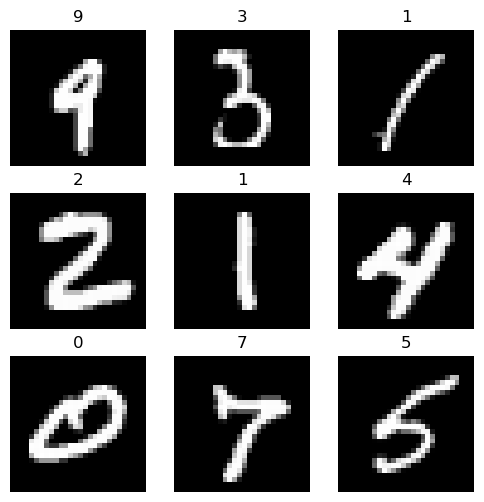

In [150]:
digits_train = DigitDataset(
    root='data',
    train=True,
    transform=ToTensor()
)

fig = plt.figure(figsize=(6, 6))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(digits_train), size=(1, )).item()
    img, label = digits_train[sample_idx]
    ax = fig.add_subplot(rows, cols, i)
    plt.axis('off')
    ax.set_title(label=str(label.item()))
    ax.imshow(img.squeeze(), cmap='gray') # type: ignore
plt.show()

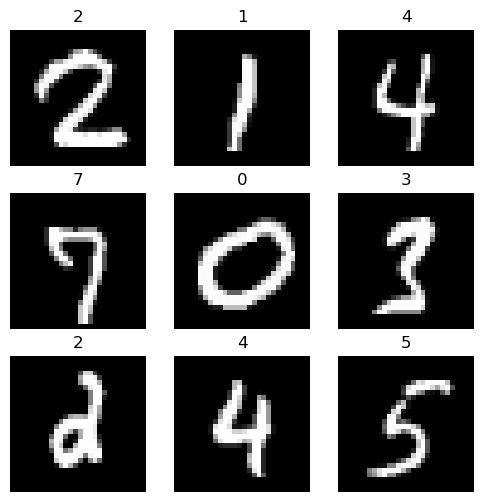

In [151]:
digits_test = DigitDataset(
    root='data',
    train=False,
    transform=ToTensor()
)

fig = plt.figure(figsize=(6, 6))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(digits_test), size=(1, )).item()
    img, label = digits_test[sample_idx]
    ax = fig.add_subplot(rows, cols, i)
    plt.axis('off')
    ax.set_title(str(label.item()))
    ax.imshow(img.squeeze(), cmap='gray') # type: ignore
plt.show()

## Constracting the neural network

In [152]:
from torch import nn

class DigitRecognizer(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.seq_layers = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.Linear(128, 10)
        )
    
    def forward(self, x):
        x = self.flatten(x)
        logits = self.seq_layers(x)
        return logits

model = DigitRecognizer()

In [153]:
model(digits_test[1][0]) # type: ignore

tensor([[ -2.3337,  12.5774,  -8.4205, -12.3941,  -5.1388,  12.0425,  -7.0442,
          -9.9005,  -3.4095,   2.0130]], grad_fn=<AddmmBackward0>)

## Training the neural networks

In [154]:
batch_size = 50

train_data = DigitDataset(
    root='data',
    train=True,
    transform=ToTensor()
)
test_data = DigitDataset(
    root='data',
    train=False,
    transform=ToTensor()
)

train_dataloader = DataLoader(
    train_data,
    batch_size=batch_size,
    shuffle=True)
test_dataloader = DataLoader(
    test_data,
    batch_size=batch_size)

In [161]:
def train_loop(dataloader, model, loss_fn, optimizer, batch_size=64):
    size = len(dataloader.dataset)
    model.train()
    
    for batch, (X, y) in enumerate(dataloader):
        logits = model(X)
        loss = loss_fn(logits, y.long())

        # backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if not batch % 100:
            loss, current = loss.item(), batch * batch_size + len(X)
            print(f'loss={loss}, current={current}/{size}')


def test_loop(dataloader, model, loss_fn):
    model.eval()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)

    test_loss, correct = 0, 0

    with torch.no_grad():
        for X, y in dataloader:
            logits = model(X)
            test_loss += loss_fn(logits, y.long()).item()
            correct += (logits.argmax(1) == y).type(torch.float32).sum().item()

    test_loss /= num_batches
    correct /= size
    print(f'Test Error:\nAccuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f}\n')

In [162]:
learning_rate = 1e-3
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

epochs = 10

for epoch in range(epochs):
    print(f'Epoch {epoch+1}----------')
    train_loop(train_dataloader, model, loss_fn, optimizer, batch_size)
    test_loop(test_dataloader, model, loss_fn)

print('Done!')

Epoch 1----------
loss=0.04909518361091614, current=50/29400
loss=0.10747101902961731, current=5050/29400
loss=0.09201928228139877, current=10050/29400
loss=0.035617560148239136, current=15050/29400
loss=0.06904638558626175, current=20050/29400
loss=0.22243504226207733, current=25050/29400
Test Error:
Accuracy: 96.6%, Avg loss: 0.115919

Epoch 2----------
loss=0.12907077372074127, current=50/29400
loss=0.11805395036935806, current=5050/29400
loss=0.16230012476444244, current=10050/29400
loss=0.013754396699368954, current=15050/29400
loss=0.06774884462356567, current=20050/29400
loss=0.07648704200983047, current=25050/29400
Test Error:
Accuracy: 97.3%, Avg loss: 0.096734

Epoch 3----------
loss=0.037467289716005325, current=50/29400
loss=0.03249011188745499, current=5050/29400
loss=0.08679160475730896, current=10050/29400
loss=0.0281709972769022, current=15050/29400
loss=0.08574029803276062, current=20050/29400
loss=0.012805393896996975, current=25050/29400
Test Error:
Accuracy: 97.7%, 